# Clustering de documents

## Imports

In [163]:
import collections
import os
import string
import sys
import re

import pandas as pd
from nltk import word_tokenize
from nltk.corpus import stopwords
from pprint import pprint
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine

In [22]:
import nltk

nltk.download('punkt')
nltk.download("punkt_tab")

[nltk_data] Downloading package punkt to /Users/ilaria/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/ilaria/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [164]:
#check repertoire courant et son contenu
import os

print("Répertoire courant :", os.getcwd())
print("Contenu du dossier courant :", os.listdir())


Répertoire courant : /Users/ilaria/Desktop/STIC/traitement_auto_corpus/tac/tps/tp3
Contenu du dossier courant : ['s3_word_embeddings.ipynb', 'README.md', 's1_classification.ipynb', 's2_clustering.ipynb']


In [165]:
data_path = "../../data/txt/"


## Choisir une décennie

In [166]:
DECADE = '1950'

## Charger tous les  fichiers de la décennie et en créer une liste de textes

In [167]:
import os
print(os.getcwd())


/Users/ilaria/Desktop/STIC/traitement_auto_corpus/tac/tps/tp3


In [168]:
# Lister tous les fichiers correspondant à la décennie
files = [f for f in sorted(os.listdir(data_path)) if f"_{DECADE}" in f]
#decade moins le denrier caractere qui est 0 donc on a 199 etc...donc on contruit un corput avec les fichers de la decennei année 50

In [169]:
# Exemple de fichiers
files[:5]

['KB_JB838_1950-01-06_01-00002.txt',
 'KB_JB838_1950-01-07_01-00013.txt',
 'KB_JB838_1950-01-08_01-00011.txt',
 'KB_JB838_1950-01-10_01-00006.txt',
 'KB_JB838_1950-01-15_01-00010.txt']

In [170]:
texts = [open(data_path + f, "r", encoding="utf-8").read() for f in files]

In [171]:
# Exemple de textes
texts[0][:400]

'/ LE SOIR Une importante manifestation franco-belge Le Comité franco-belge du Commerce, de l’Industrie et de l’Agriculture qui. au cours de l’année écoulée et dans les circonstances les plus difficiles a rendu aux relations économiques entre les deux pays des services considérables, donnera le 12 janvier, à 19 h. 30, un dîner à l’occasion de l’anniversaire de son installation. Ce comité, qui fonct'

## Vectoriser les documents à l'aide de TF-IDF

In [173]:
# Création d'une fonction de pré-traitement, tokenization et suppression de la ponctuation
def preprocessing(text, stem=True):
    """ Tokenize text, remove punctuation, and remove French stopwords """
    # Supprimer la ponctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Tokenization
    tokens = word_tokenize(text)
    
    # Supprimer les stopwords français
    tokens = [t for t in tokens if t.lower() not in stopwords.words('french')]
    
    return tokens


### Instancier le modèle TF-IDF avec ses arguments

In [174]:
vectorizer = TfidfVectorizer(
    tokenizer=preprocessing,
    stop_words=stopwords.words('french'),
    max_df=0.5,
    min_df=0.01,
    lowercase=True)

### Construire la matrice de vecteurs à l'aide de la fonction `fit_transform`

In [175]:
tfidf_vectors = vectorizer.fit_transform(texts)
#on recupere nos vecteurs sur les textes et on va trouevr la matrice

/Users/ilaria/Desktop/STIC/traitement_auto_corpus/tac/.venv/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [176]:
# Détail de la matrice
tfidf_vectors
# et vérifie le nombre de documents et de mots, numero documents 1000,  numeros mots 3506

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 201058 stored elements and shape (100, 76958)>

### Imprimer le vecteur tf-IDF du premier document

In [177]:
pd.Series(
    tfidf_vectors[0].toarray()[0],
    index=vectorizer.get_feature_names_out()
    ).sort_values(ascending=False)
#voir comment on petucalculer les distances entres les vecteurs pour s'entraine r et comprendre ce modele
#calculer l'angle des vecteus qui donne le cosinus, mêmes vecteurs la distance est 0; distance (0 veut dire qucoune distance ou 1)
#  et similarité (-1 à 1) donce les deux ne sont pas à confondre

matisse              0.226940
parti                0.174255
locataire            0.144399
malenkov             0.140873
piasecki             0.123264
                       ...   
claudie              0.000000
claudette            0.000000
claudel              0.000000
claudefrançois       0.000000
✓wwvvwvvvvwvwvwwv    0.000000
Length: 76958, dtype: float64

## Comprendre les vecteurs et leurs "distances"

In [178]:
cosine([1, 2, 3], [1, 2, 3])

np.float64(0.0)

In [179]:
cosine([1, 2, 3], [1, 2, 2])

np.float64(0.02004211298777725)

In [180]:
cosine([1, 2, 3], [2, 2, 2])

np.float64(0.07417990022744858)

### Tests sur nos documents

In [181]:
tfidf_array = tfidf_vectors.toarray()

In [182]:
# Vecteur du document 0
tfidf_array[0]

array([0., 0., 0., ..., 0., 0., 0.], shape=(76958,))

In [183]:
# Vecteur du document 1
tfidf_array[1]

array([0.00789567, 0.        , 0.01567263, ..., 0.        , 0.        ,
       0.        ], shape=(76958,))

In [184]:
cosine(tfidf_array[0], tfidf_array[1])

np.float64(0.9679343710539111)

## Appliquer un algorithme de clustering sur les vecteurs TF-IDF des documents

Pour en savoir plus sur le KMeans clustering :
- https://medium.com/dataseries/k-means-clustering-explained-visually-in-5-minutes-b900cc69d175

### Définir un nombre de clusters

In [185]:
N_CLUSTERS = 3

### Instancier le modèle K-Means et ses arguments

In [186]:
km_model = KMeans(n_clusters=N_CLUSTERS)

### Appliquer le clustering à l'aide de la fonction `fit_predict`

In [187]:
clusters = km_model.fit_predict(tfidf_vectors)
#fit_predic renvoye des clusters poru chaque document

In [188]:
clustering = collections.defaultdict(list)

for idx, label in enumerate(clusters):
    clustering[label].append(files[idx])

In [189]:
pprint(dict(clustering))

{np.int32(0): ['KB_JB838_1950-01-06_01-00002.txt',
               'KB_JB838_1950-01-10_01-00006.txt',
               'KB_JB838_1950-01-15_01-00010.txt',
               'KB_JB838_1950-02-13_01-00005.txt',
               'KB_JB838_1950-02-13_01-00008.txt',
               'KB_JB838_1950-02-17_01-00009.txt',
               'KB_JB838_1950-02-18_01-00009.txt',
               'KB_JB838_1950-02-25_01-00006.txt',
               'KB_JB838_1950-03-01_01-00005.txt',
               'KB_JB838_1950-03-05_01-00020.txt',
               'KB_JB838_1950-03-11_01-00005.txt',
               'KB_JB838_1950-03-19_01-00001.txt',
               'KB_JB838_1950-03-25_01-00009.txt',
               'KB_JB838_1950-03-27_01-00002.txt',
               'KB_JB838_1950-03-29_01-00002.txt',
               'KB_JB838_1950-03-31_01-00006.txt',
               'KB_JB838_1950-04-19_01-00002.txt',
               'KB_JB838_1950-04-26_01-00007.txt',
               'KB_JB838_1950-05-03_01-00006.txt',
               'KB_JB838_1950-0

## Visualiser les clusters

### Réduire les vecteurs à 2 dimensions à l'aide de l'algorithme PCA
Cette étape est nécessaire afin de visualiser les documents dans un espace 2D

https://fr.wikipedia.org/wiki/Analyse_en_composantes_principales

In [190]:
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(tfidf_vectors.toarray())

In [191]:
reduced_vectors[:10]

array([[-0.23338679,  0.07755059],
       [ 0.04487192, -0.12256365],
       [ 0.28836019, -0.32497111],
       [-0.22685293,  0.04010586],
       [-0.11168097, -0.12135612],
       [ 0.55621595,  0.44933394],
       [-0.24830981,  0.06208981],
       [-0.20037461,  0.00893803],
       [ 0.58368643,  0.4159472 ],
       [ 0.01444063,  0.00840393]])

### Générer le plot

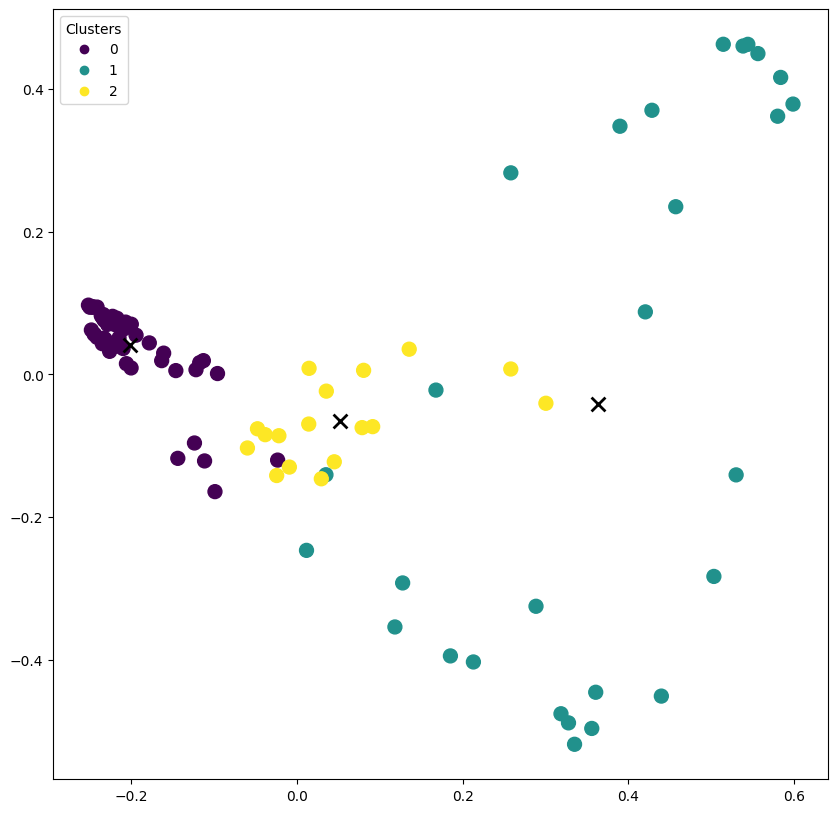

In [192]:
x_axis = reduced_vectors[:, 0]
y_axis = reduced_vectors[:, 1]

plt.figure(figsize=(10,10))
scatter = plt.scatter(x_axis, y_axis, s=100, c=clusters)

# Ajouter les centroïdes
centroids = pca.transform(km_model.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1],  marker = "x", s=100, linewidths = 2, color='black')

# Ajouter la légende
plt.legend(handles=scatter.legend_elements()[0], labels=set(clusters), title="Clusters")

#par l'image: on se rend compte qu epeut êre 5 cluster etions trop et put etre meuilleur resultat en reduisant le clistur no pas à 5
#de manière iterative on peut voir si on peut organiser l'ensemble dans un ensemble plus coherent (exercice pour le tp)

## Analyse mots clef

In [193]:
top_keywords = 10
for cluster_id, docs in cluster_docs.items():
    all_text = " ".join(docs)
    frequencies = Counter(all_text.split())
    print(f"Cluster {cluster_id} :")
    print(frequencies.most_common(top_keywords))


Cluster 0 :
[('TÉL', 1645), ('RUE', 1257), ('ECR', 633), ('ECRIRE', 604), ('BRUX', 434), ('CONF', 431), ('MAISON', 428), ('LOUER', 390), ('LIBRE', 384), ('PRIX', 376)]
Cluster 1 :
[('RUE', 411), ('ANS', 312), ('GRAND', 305), ('LIEU', 280), ('BELGIQUE', 268), ('GRANDE', 265), ('PRIX', 255), ('COURS', 254), ('TEMPS', 253), ('PRÉSIDENT', 252)]
Cluster 2 :
[('TÉL', 470), ('RUE', 364), ('PRIX', 211), ('FORD', 200), ('ÉTAT', 200), ('CRÉDIT', 134), ('VEND', 122), ('RENAULT', 121), ('BRUX', 119), ('CHEVROLET', 112)]


## Nouage de mots

### Nettoyage des textes

In [ ]:
from nltk.corpus import stopwords
import nltk
from collections import Counter

nltk.download('stopwords')
sw = stopwords.words("french")
sw += [
    "a", "à", "â", "abord", "afin", "ah", "ai", "aie", "aient", "aies", "ailleurs", "ainsi", "ait", "allaient",
    "allo", "allô", "alors", "anterieur", "anterieure", "anterieures", "apres", "après", "as", "assez", "attendu",
    "au", "aucun", "aucune", "aujourd", "aujourd'hui", "aupres", "auquel", "aura", "auraient", "aurait", "auront",
    "aussi", "autre", "autres", "autrui", "aux", "auxquelles", "auxquels", "avaient", "avais", "avait", "avant",
    "avec", "avez", "aviez", "avions", "avoir", "avons", "ayant", "b", "bah", "bas", "basee", "bat", "beau",
    "beaucoup", "bien", "bigre", "bon", "boum", "bravo", "brrr", "c", "ça", "car", "ce", "ceci", "cela", "celle",
    "celle-ci", "celle-là", "celles", "celles-ci", "celles-là", "celui", "celui-ci", "celui-là", "cent", "cependant",
    "certain", "certaine", "certaines", "certains", "certes", "ces", "cet", "cette", "ceux", "ceux-ci", "ceux-là",
    "chacun", "chaque", "cher", "chers", "chez", "chiche", "chut", "chère", "chères", "ci", "cinq", "cinquantaine",
    "cinquante", "cinquantième", "cinquième", "clac", "clic", "combien", "comme", "comment", "comparable", "comparables",
    "compris", "concernant", "contre", "couic", "crac", "d", "da", "dans", "de", "debout", "dedans", "dehors", "delà",
    "depuis", "dernier", "derniere", "derrière", "des", "dès", "desormais", "desquelles", "desquels", "dessous",
    "dessus", "deux", "deuxième", "deuxièmement", "devant", "devers", "devra", "different", "differentes", "differents",
    "différent", "différente", "différentes", "différents", "dire", "directe", "directement", "dit", "dite", "dits",
    "divers", "diverse", "diverses", "dix", "dix-huit", "dix-neuf", "dix-sept", "dixième", "doit", "doivent", "donc",
    "dont", "douze", "douzième", "dring", "du", "duquel", "durant", "dès", "dés", "désormais", "e", "effet", "egale",
    "egalement", "egales", "eh", "elle", "elle-même", "elles", "elles-mêmes", "en", "encore", "enfin", "entre", "envers",
    "environ", "es", "est", "et", "etant", "etc", "etre", "eu", "eue", "eues", "euh", "eurent", "eus", "eusse", "eussent",
    "eusses", "eussi", "eussiez", "eussions", "eux", "eux-mêmes", "exactement", "excepté", "extenso", "exterieur",
    "f", "fais", "faisaient", "faisant", "fait", "faites", "façon", "feront", "fi", "flac", "floc", "font", "g", "gens",
    "h", "ha", "hé", "hein", "hem", "hep", "hi", "ho", "holà", "hop", "hormis", "hors", "hou", "houp", "hue", "hui",
    "huit", "huitième", "hum", "hurrah", "hé", "i", "il", "ils", "importe", "j", "je", "jusqu", "jusque", "juste",
    "k", "l", "la", "là", "laquelle", "las", "le", "lequel", "les", "lesquelles", "lesquels", "leur", "leurs", "longtemps",
    "lors", "lorsque", "lui", "lui-même", "m", "ma", "maint", "maintenant", "mais", "malgre", "malgré", "même", "mêmes",
    "merci", "mes", "mien", "mienne", "miennes", "miens", "mille", "mince", "mine", "moins", "mon", "mot", "moyennant",
    "n", "na", "naturel", "naturelle", "naturelles", "ne", "néanmoins", "necessaire", "necessairement", "neuf", "neuvième",
    "ni", "nombreuses", "nombreux", "non", "nos", "notamment", "notre", "nous", "nous-mêmes", "nul", "o", "ô", "oh", "ohé",
    "ollé", "olé", "on", "ont", "onze", "onzième", "ore", "ou", "où", "ouf", "ouias", "oust", "ouste", "outre", "p", "paf",
    "par", "parce", "parfois", "parle", "parlent", "parler", "parmi", "parseme", "partant", "particulier", "particulière",
    "particulièrement", "pas", "passé", "pendant", "pense", "permet", "personne", "peu", "peut", "peuvent", "peux", "pff",
    "pfft", "pfut", "pif", "plein", "plouf", "plus", "plutôt", "pouah", "pour", "pourquoi", "premier", "première",
    "premièrement", "pres", "près", "proche", "psitt", "puis", "puisque", "pur", "q", "qu", "quand", "quant", "quanta",
    "quarante", "quatorze", "quatre", "quatre-vingt", "quatrième", "que", "quel", "quelconque", "quelle", "quelles",
    "quelqu'un", "quelque", "quelques", "quels", "qui", "quiconque", "quinze", "quoi", "quoique", "r", "revoici",
    "revoilà", "rien", "s", "sa", "sans", "sapristi", "sauf", "se", "sein", "seize", "selon", "semblable", "semblaient",
    "semble", "semblent", "sent", "sept", "septième", "sera", "seraient", "serait", "seront", "ses", "seul", "seule",
    "seulement", "si", "sien", "sienne", "siennes", "siens", "sinon", "six", "sixième", "soi", "soi-même", "soit",
    "soixante", "son", "sont", "sous", "souvent", "specifique", "specifiques", "speculatif", "stop", "strictement",
    "subtiles", "suffisant", "suffisante", "suffit", "suis", "surtout", "t", "ta", "tac", "tant", "te", "tel", "telle",
    "tellement", "telles", "tels", "tenant", "tes", "tic", "tien", "tienne", "tiennes", "tiens", "toc", "toi", "toi-même",
    "ton", "touchant", "toujours", "tous", "tout", "toute", "toutes", "treize", "trente", "très", "trois", "troisième",
    "trop", "tu", "u", "un", "une", "unes", "uns", "v", "va", "vais", "vas", "vé", "vers", "via", "vif", "vifs", "vingt",
    "vivat", "vive", "vives", "vlan", "voici", "voie", "voient", "voilà", "voire", "vos", "votre", "vous", "vous-mêmes",
    "vu", "vut", "w", "x", "y", "z", "zut","soir","tel",
    "les", "plus", "cette", "fait", "faire", "être", "deux", "comme", "dont", "tout", "ils", "bien", "sans", "peut",
    "tous", "après", "ainsi", "donc", "cet", "sous", "celle", "entre", "encore", "toutes", "pendant", "moins", "dire",
    "cela", "non", "faut", "trois", "aussi", "dit", "avoir", "doit", "contre", "depuis", "autres", "van", "het", "autre",
    "jusqu", "ville", "rossel", "dem", "etxc", "elles", "dés", "prixx", "écr", "géné", "app", "adr", "mod", "bur",
    "trav", "et", "de", "à", "en", "le", "la", "du", "des", "aux", "un", "une"," rue","bruxelles", "soir","tel",'louer', 
    'villa', 'jard', 'bel', 'réf', 'servante', 'vendre', 'rez', 'appart', 'pers'
]
sw = set([w.lower() for w in sw])  # assurer tout en minuscules et unique

def clean_text_string(text):
    words = nltk.wordpunct_tokenize(text)
    kept = [w for w in words if len(w) > 2 and w.isalpha() and w.lower() not in sw]
    return " ".join(kept)

cleaned_texts = [clean_text_string(text) for text in texts]


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ilaria/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Préparation des clusters pour WordCloud

In [198]:
import os

# Associer les textes nettoyés à chaque cluster
cluster_docs = {i: [] for i in range(N_CLUSTERS)}
for doc, label in zip(cleaned_texts, clusters):
    cluster_docs[label].append(doc)

# Créer un dossier pour les WordClouds
wc_path = "../../data/tmp_wordclouds/"
os.makedirs(wc_path, exist_ok=True)


### Génération et affichage des WordCloud + top keywords

/Users/ilaria/Desktop/STIC/traitement_auto_corpus/tac/.venv/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['quelqu', 'rue'] not in stop_words.
  warnings.warn(


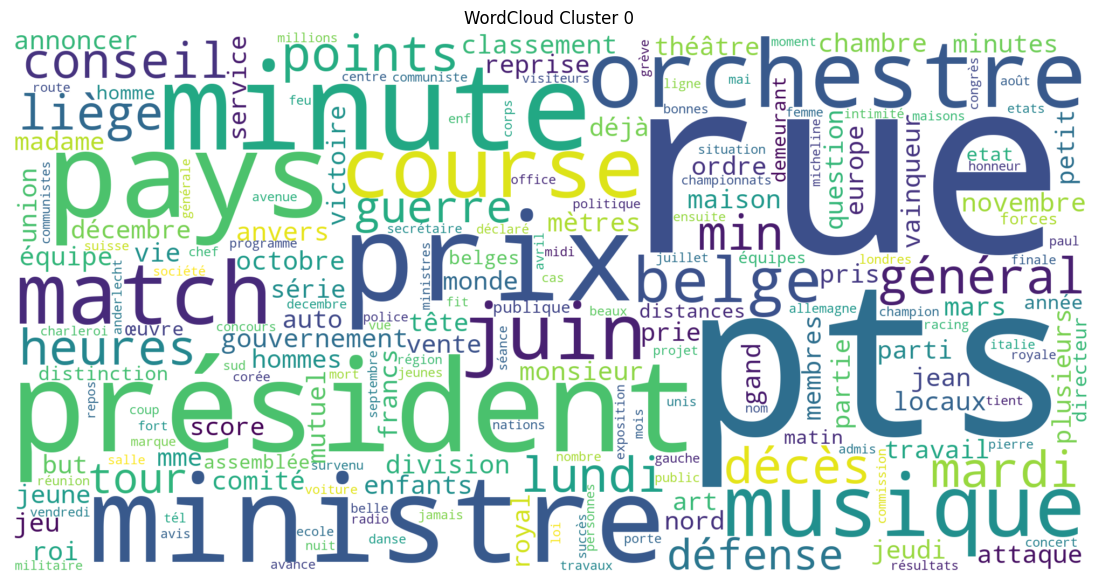

Cluster 0 - Top 10 mots :
['rue', 'pts', 'président', 'prix', 'ministre', 'minute', 'pays', 'orchestre', 'musique', 'match']

--------------------------------------------------



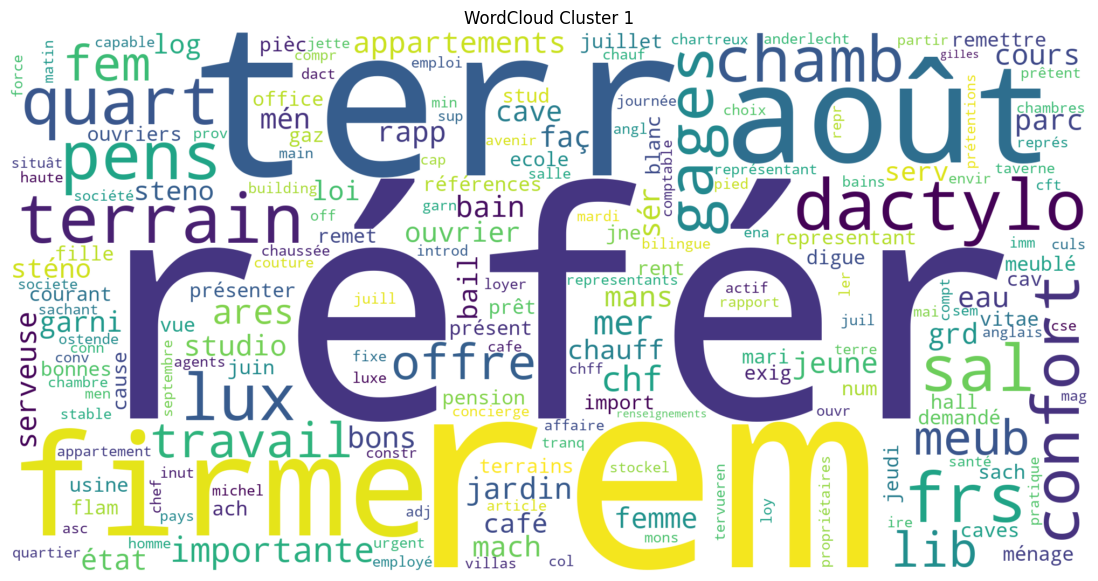

Cluster 1 - Top 10 mots :
['référ', 'rem', 'terr', 'firme', 'août', 'dactylo', 'terrain', 'frs', 'pens', 'quart']

--------------------------------------------------



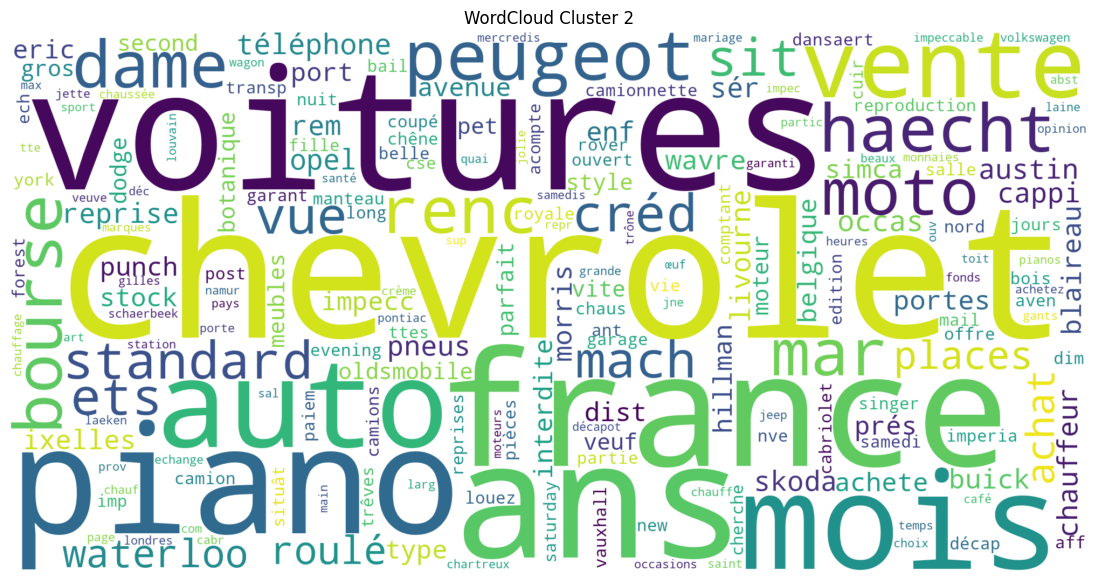

Cluster 2 - Top 10 mots :
['chevrolet', 'voitures', 'ans', 'france', 'piano', 'mois', 'auto', 'vente', 'peugeot', 'bourse']

--------------------------------------------------



In [201]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
import os

top_keywords = 10

# Boucle sur les clusters
for cluster_id, docs in cluster_docs.items():
    # TF-IDF pour les documents du cluster
    vectorizer = TfidfVectorizer(max_df=0.8, min_df=2, stop_words=list(sw))  # Ajuste stop_words selon langue
    tfidf_matrix = vectorizer.fit_transform(docs)
    
    # Somme des TF-IDF pour chaque mot dans le cluster
    summed_tfidf = np.array(tfidf_matrix.sum(axis=0)).flatten()
    words = np.array(vectorizer.get_feature_names_out())
    
    # Créer un dictionnaire mot -> importance
    tfidf_scores = dict(zip(words, summed_tfidf))
    
    # WordCloud
    cloud = WordCloud(width=2000, height=1000, background_color='white').generate_from_frequencies(tfidf_scores)
    file_name = os.path.join(wc_path, f"cluster_{cluster_id}.png")
    cloud.to_file(file_name)
    
    # Affichage dans le notebook
    plt.figure(figsize=(15,7))
    plt.imshow(cloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"WordCloud Cluster {cluster_id}")
    plt.show()
    
    # Affichage top keywords
    top_words = sorted(tfidf_scores.items(), key=lambda x: x[1], reverse=True)[:top_keywords]
    print(f"Cluster {cluster_id} - Top {top_keywords} mots :")
    print([word for word, score in top_words])
    print("\n" + "-"*50 + "\n")
